In [1]:
# 数据接口 
import akshare as ak
import baostock as bs
import tushare as ts

# 基础模块
import datetime
from itertools import product
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time

# 回测框架
import backtrader as bt

# 基础函数
import utilsJ

# 策略

### 现有指标：
+ 均线 
+ 布林带
+ MACD柱状图
+ RSI相对强弱
+ WilliamR指标

In [2]:
class Strategy_comp_winrate(bt.Strategy):
    
    params = (
        # General params
        ('printlog', False),
        ('p_stake', 100),
        ('buy_signal', 'b'),
        ('sell_signal', 'b'),

        # Indicator params
        ('bollinger_per', 20),
        ('bollinger_dev', 2),
        ('rsi_short', 6),
        ('rsi_long', 12),
        ('wave_period', 7),
        ('wr', 14),
        
        # ATR params
        ('using_atr', False),
        ('atr_period', 14),
        ('atr_percent', 1),
    )
    
    
    def log(self, txt, dt=None, doprint=False):
        if self.params.printlog or doprint:
            dt = dt or self.datas[0].datetime.date(0)
            print('%s: %s' % (dt.isoformat(), txt))
            #with open('log.txt', 'a') as file:
                #file.write('%s: %s \n' % (dt.isoformat(), txt))
        
    
    def __init__(self):
        # Keep references to lines in the data[0] dataseries
        self.dataclose = self.datas[0].close
        self.datahigh = self.datas[0].high
        self.datalow = self.datas[0].low

        # Keep references to executed order & price
        self.buyprice = 0
        self.sellprice = 0
        self.order = None

        # Add indicators
        ## Wave indicator
        ### MovingAverageSimple indicator
        self.sma = bt.indicators.SimpleMovingAverage(self.datas[0], period=self.params.wave_period)
        self.wave_buy = bt.And(self.sma(0) > self.sma(-1), self.sma(-1) < self.sma(-2), self.sma(-2) < self.sma(-3))
        self.wave_sell = bt.And(self.sma(0) < self.sma(-1), self.sma(-1) > self.sma(-2), self.sma(-2) > self.sma(-3))

        ## MACD indicator
        self.macdhisto = bt.indicators.MACDHisto(self.datas[0])
        self.macd_buy = bt.And(self.macdhisto.histo(0) > 0, self.macdhisto.histo(-1) < 0)
        self.macd_sell = bt.And(self.macdhisto.histo(0) < 0, self.macdhisto.histo(-1) > 0)
        
        ## Bollinger Bands indicator
        self.bolling = bt.indicators.BollingerBands(self.datas[0], 
                                                    period = self.params.bollinger_per, 
                                                    devfactor = self.params.bollinger_dev)
        self.bolling_buy = bt.Or(bt.And(self.dataclose(0) > self.bolling.top(0), self.dataclose(-1) < self.bolling.top(-1)), 
                                 bt.And(self.dataclose(0) > self.bolling.bot(0), self.dataclose(-1) < self.bolling.bot(-1)))
        self.bolling_sell = bt.Or(bt.And(self.dataclose(0) < self.bolling.top(0), self.dataclose(-1) > self.bolling.top(-1)), 
                                  bt.And(self.dataclose(0) < self.bolling.bot(0), self.dataclose(-1) > self.bolling.bot(-1)))

        ## RSI indicator
        self.rsi_s = bt.indicators.RelativeStrengthIndex(period=self.params.rsi_short, safediv=True)
        self.rsi_l = bt.indicators.RelativeStrengthIndex(period=self.params.rsi_long, safediv=True)
        self.rsi_buy = bt.And(self.rsi_s(0) > self.rsi_l(0), self.rsi_s(-1) < self.rsi_l(-1))
        self.rsi_sell = bt.And(self.rsi_s(0) < self.rsi_l(0), self.rsi_s(-1) > self.rsi_l(-1))

        ## WilliamR indicator
        self.wr = bt.indicators.WilliamsR(period=self.params.wr)
        self.wr_buy = self.wr < -80
        self.wr_sell = self.wr > -20

        ## ATR indicator
        self.atr_initial = self.broker.get_cash()
        self.tr = bt.indicators.Max((self.datahigh - self.datalow), 
                                    abs(self.dataclose(-1) - self.datahigh),
                                    abs(self.dataclose(-1) - self.datalow))
        self.atr = bt.indicators.SimpleMovingAverage(self.tr, period=self.params.atr_period)

        self.pos_trade = 0
        self.neg_trade = 0


    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.buyprice = order.executed.price
                self.log('BUY EXECUTED, Price:%.2f, Lot:%i, Cash:%i.' %
                         (order.executed.price,
                          order.executed.size,
                          self.broker.get_cash()))

            else:  # Sell
                self.sellprice = order.executed.price
                self.log('SELL EXECUTED, Price:%.2f, Lot:%i, Cash:%i.' %
                        (order.executed.price,
                          -order.executed.size,
                          self.broker.get_cash()))

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        #self.order = None


    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))
    

    def next(self):
        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return

        buy_indicator = (self.params.buy_signal == 'b' and self.bolling_buy) or \
                        (self.params.buy_signal == 'm' and self.macd_buy) or \
                        (self.params.buy_signal == 'w' and self.wave_buy) or \
                        (self.params.buy_signal == 'r' and self.rsi_buy) or \
                        (self.params.buy_signal == 'wr' and self.wr_buy)
                        
        sell_indicator = (self.params.sell_signal == 'b' and self.bolling_sell) or \
                         (self.params.sell_signal == 'm' and self.macd_sell) or \
                         (self.params.sell_signal == 'w' and self.wave_sell) or \
                         (self.params.sell_signal == 'r' and self.rsi_sell) or \
                         (self.params.sell_signal == 'wr' and self.wr_sell)
            
        if buy_indicator and self.dataclose[0] > self.bolling.mid[0]:
            if self.params.using_atr:
                opt_pos = np.round(self.atr_initial * self.params.atr_percent / self.params.p_stake / self.atr[0])
                if opt_pos*self.params.p_stake > 0 and self.getposition(self.data).size < opt_pos*self.params.p_stake:
                    self.log('BUY CREATE, Price: %.2f, Lots: %i, Current Position: %i' % 
                             (self.dataclose[0], 
                             opt_pos*self.params.p_stake-self.getposition(self.data).size,
                             self.getposition(self.data).size))
                    self.buy(size=opt_pos*self.params.p_stake-self.getposition(self.data).size)
                
                #elif opt_pos*self.params.p_stake > 0 and self.getposition(self.data).size > opt_pos*self.params.p_stake:
                #    self.log('SELL CREATE, Price: %.2f, Lots: %i, Current Position: %i' % 
                #            (self.dataclose[0], 
                #            self.getposition(self.data).size-opt_pos*self.params.p_stake,
                #            self.getposition(self.data).size))
                #    self.sell(size=self.getposition(self.data).size-opt_pos*self.params.p_stake)
            else:
                self.log('BUY CREATE, Price: %.2f, Lots: %i, Current Position: %i' % (self.dataclose[0], 
                        self.params.p_stake,
                        self.getposition(self.data).size))
                self.buy(size=self.params.p_stake)
        elif sell_indicator and self.getposition(self.data).size > 0:
            self.log('Sell CREATE(Close), Price: %.2f, Current Position: %i' % (self.dataclose[0],
                        self.getposition(self.data).size))
            self.close()


    def stop(self):
        self.log('Ending Position:%i. Ending Value:%.2f.' %
                (self.getposition(self.data).size,
                self.cerebro.broker.getvalue()), doprint=False)

### 沪深300循环回测

In [105]:
idx = '399300.SZ'

s_date = datetime.date(2020,12,31) - datetime.timedelta(days=385)
e_date = datetime.date(2020,12,31)

pro = ts.pro_api('74f1379591c9d810854fa5891fffcacaba514b82bf17ec2e239025b6')
index_list = np.unique(pro.index_weight(index_code=idx,
                                        start_date=s_date.strftime('%Y%m%d'),
                                        end_date=e_date.strftime('%Y%m%d')).con_code).tolist()
buy_s = ['b','m','w', 'r', 'wr']
sell_s = ['b','m','w', 'r', 'wr']

if __name__ == '__main__':
    profit_stk = dict()
    for stk in index_list:
        profit_ind = dict()
        for s in product(*[buy_s, sell_s]):

            # Create a cerebro entity
            cerebro = bt.Cerebro()

            # Add a strategy
            strats = cerebro.addstrategy(Strategy_comp_winrate, printlog=False, using_atr=True, atr_percent=0.02, buy_signal = s[0], sell_signal = s[1]) 

            s_date = datetime.date(2020,12,31) - datetime.timedelta(days=385)
            e_date = datetime.date(2020,12,31)

            # Create stock Data Feed
            #df = utilsJ.stock_tushare('74f1379591c9d810854fa5891fffcacaba514b82bf17ec2e239025b6', 
            #                    stock_index, s_date, e_date)
            df = pd.read_csv('.\\Data\\2019\\'+stk+'.csv', 
                            converters={'trade_date':lambda x:pd.to_datetime(x)}).set_index('trade_date')
            data = bt.feeds.PandasData(dataname=df,fromdate=s_date,todate=e_date)

            # Add the index Data Feed to Cerebo
            cerebro.adddata(data)

            # Set cash inside the strategy
            cerebro.broker = bt.brokers.BackBroker(coc=True)   
            cerebro.broker.setcash(1000000)

            # Set commission
            #cerebro.broker.setcommission()

            # Print out the starting conditions
            start_value = cerebro.broker.getvalue()
            #print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

            # Run over everything
            cerebro.run()

            # Print out the final result
            final_value = cerebro.broker.getvalue()
            #print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
            #print('Net Profit: %.2f%%' % ((final_value - start_value) / start_value * 100))
            profit_ind[s] = (final_value - start_value) / start_value * 100
        print((stk, sorted(profit_ind.items(), key=lambda x: x[1], reverse=True)[:3]))
        profit_stk[stk] = sorted(profit_ind.items(), key=lambda x: x[1], reverse=True)

[(('b', 'wr'), 12.3192), (('r', 'w'), 12.2723), (('r', 'm'), 10.8052)]
[(('r', 'wr'), 15.613399999999999), (('r', 'b'), 12.704299999999998), (('m', 'wr'), 9.9099)]
[(('w', 'w'), 6.6362000000000005), (('m', 'w'), 5.9782), (('w', 'b'), 5.9318)]
[(('b', 'r'), 18.0058), (('r', 'm'), 15.468599999999999), (('r', 'w'), 15.345400000000001)]
[(('m', 'm'), 15.6745), (('r', 'b'), 13.7484), (('b', 'r'), 11.9141)]
[(('r', 'b'), 26.4835), (('m', 'b'), 17.4974), (('r', 'wr'), 12.7905)]
[(('r', 'w'), 36.1515), (('b', 'r'), 28.0762), (('b', 'b'), 27.7694)]
[(('b', 'b'), 17.515900000000002), (('b', 'r'), 13.0584), (('b', 'w'), 9.6822)]
[(('b', 'm'), 30.566), (('m', 'm'), 25.404600000000045), (('b', 'w'), 19.1541)]
[(('m', 'b'), 20.2736), (('m', 'wr'), 19.903100000000002), (('m', 'w'), 18.371499999999997)]
[(('m', 'wr'), 12.682699999999999), (('r', 'wr'), 2.6561000000000003), (('wr', 'b'), 0.0)]
[(('b', 'b'), 7.248200000000023), (('b', 'wr'), 5.5376), (('b', 'r'), 4.9502999999999995)]
[(('r', 'wr'), 23.3

[(('b', 'wr'), 9.2652), (('r', 'wr'), 8.9616), (('w', 'b'), 6.1429)]
[(('r', 'b'), 11.2534), (('r', 'wr'), 10.0102), (('r', 'r'), 8.777)]
[(('m', 'm'), 14.352), (('m', 'b'), 8.7859), (('b', 'r'), 4.663200000000012)]
[(('r', 'b'), 24.7788), (('b', 'wr'), 21.837200000000003), (('r', 'r'), 20.1203)]
[(('b', 'b'), 53.003699999999995), (('w', 'b'), 48.8003), (('m', 'b'), 31.487199999999998)]
[(('wr', 'b'), 0.0), (('wr', 'm'), 0.0), (('wr', 'w'), 0.0)]
[(('r', 'b'), 11.068), (('r', 'w'), 7.657500000000001), (('r', 'r'), 6.8545)]
[(('r', 'm'), 23.0647), (('r', 'w'), 17.3931), (('b', 'wr'), 9.7192)]
[(('r', 'b'), 18.165899999999997), (('w', 'b'), 17.6308), (('w', 'wr'), 14.29)]
[(('w', 'b'), 8.2627), (('r', 'b'), 7.5783000000000005), (('m', 'm'), 5.4666)]
[(('m', 'wr'), 0.2889), (('wr', 'b'), 0.0), (('wr', 'm'), 0.0)]
[(('m', 'w'), 35.326), (('m', 'r'), 34.4344), (('r', 'm'), 23.409299999999998)]
[(('r', 'w'), 26.392500000000002), (('b', 'w'), 23.288600000000024), (('b', 'm'), 20.4239)]
[(('r'

[(('r', 'm'), 31.9726), (('w', 'w'), 29.766900000000003), (('b', 'm'), 29.104999999999997)]
[(('r', 'b'), 54.6528), (('r', 'w'), 38.5577), (('b', 'r'), 31.4046)]
[(('m', 'b'), 9.8162), (('b', 'b'), 6.3947), (('r', 'w'), 4.557699999999988)]
[(('b', 'w'), 17.1253), (('b', 'm'), 16.8165), (('r', 'r'), 15.420700000000002)]
[(('w', 'm'), 37.4361), (('r', 'm'), 36.210300000000025), (('w', 'r'), 35.5478)]
[(('r', 'b'), 11.2423), (('m', 'b'), 3.0629), (('b', 'wr'), 0.7582000000000116)]
[(('w', 'wr'), 1.3050000000000002), (('w', 'r'), 1.1310000000000118), (('w', 'w'), 0.43500000000001166)]
[(('r', 'm'), 36.7978), (('r', 'w'), 34.0946), (('r', 'b'), 27.744400000000002)]
[(('b', 'r'), 5.9593), (('w', 'w'), 5.4096), (('b', 'wr'), 3.9607)]
[(('r', 'r'), 25.918999999999997), (('r', 'b'), 20.456599999999998), (('r', 'm'), 15.842)]
[(('m', 'm'), 22.3982), (('b', 'm'), 17.496100000000002), (('b', 'wr'), 15.9254)]
[(('r', 'b'), 31.3643), (('m', 'b'), 24.7347), (('r', 'w'), 21.159)]
[(('r', 'r'), 19.7704

KeyboardInterrupt: 

In [106]:
profit_stk

{'000001.SZ': [(('b', 'wr'), 12.3192),
  (('r', 'w'), 12.2723),
  (('r', 'm'), 10.8052),
  (('r', 'r'), 10.322000000000001),
  (('w', 'm'), 9.2709),
  (('w', 'r'), 8.235299999999999),
  (('m', 'b'), 8.1938),
  (('w', 'w'), 8.0078),
  (('r', 'b'), 7.9042),
  (('b', 'r'), 7.695499999999999),
  (('m', 'r'), 5.069),
  (('w', 'b'), 4.495899999999988),
  (('m', 'm'), 2.978999999999988),
  (('b', 'b'), 1.8135),
  (('m', 'w'), 1.4305999999999883),
  (('r', 'wr'), 0.2891000000000117),
  (('wr', 'b'), 0.0),
  (('wr', 'm'), 0.0),
  (('wr', 'w'), 0.0),
  (('wr', 'r'), 0.0),
  (('wr', 'wr'), 0.0),
  (('b', 'w'), -0.8201999999999999),
  (('b', 'm'), -2.9838999999999882),
  (('m', 'wr'), -3.280599999999988),
  (('w', 'wr'), -5.665700000000012)],
 '000002.SZ': [(('r', 'wr'), 15.613399999999999),
  (('r', 'b'), 12.704299999999998),
  (('m', 'wr'), 9.9099),
  (('m', 'b'), 9.3544),
  (('b', 'wr'), 4.583300000000012),
  (('w', 'b'), 0.0),
  (('w', 'r'), 0.0),
  (('wr', 'b'), 0.0),
  (('wr', 'm'), 0.0),
  

# 单股回测

In [108]:
if __name__ ==  '__main__':
    # Create a cerebro entity
    cerebro = bt.Cerebro()

    # Add a strategy
    strats = cerebro.addstrategy(Strategy_comp_winrate, printlog=True, using_atr=True, atr_percent=0.02, buy_signal = 'b', sell_signal = 'm') 

    s_date = datetime.date(2020,12,31) - datetime.timedelta(days=385)
    e_date = datetime.date(2020,12,31)

    # Create stock Data Feed
    stock_index = '601216.SH'
    #df = utilsJ.stock_tushare('74f1379591c9d810854fa5891fffcacaba514b82bf17ec2e239025b6', 
    #                    stock_index, s_date, e_date)
    df = pd.read_csv('.\\Data\\2019\\' + stock_index + '.csv', converters={'trade_date':lambda x:pd.to_datetime(x)}).set_index('trade_date')
    data = bt.feeds.PandasData(dataname=df,fromdate=s_date,todate=e_date)

    # Add the index Data Feed to Cerebo
    cerebro.adddata(data)

    # Set cash inside the strategy
    cerebro.broker = bt.brokers.BackBroker(coc=True)   
    cerebro.broker.setcash(20000)

    # Set commission
    #cerebro.broker.setcommission()

    # Print out the starting conditions
    start_value = cerebro.broker.getvalue()
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # Run over everything
    cerebro.run()

    # Print out the final result
    final_value = cerebro.broker.getvalue()
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
    print('Net Profit: %.2f%%' % ((final_value - start_value) / start_value * 100))

Starting Portfolio Value: 20000.00
2020-04-22: BUY CREATE, Price: 2.82, Lots: 4300, Current Position: 0
2020-04-23: BUY EXECUTED, Price:2.82, Lot:4300, Cash:7874.
2020-05-15: Sell CREATE(Close), Price: 2.81, Current Position: 4300
2020-05-18: SELL EXECUTED, Price:2.81, Lot:4300, Cash:19957.
2020-05-18: OPERATION PROFIT, GROSS -43.00, NET -43.00
2020-06-22: BUY CREATE, Price: 2.61, Lots: 8700, Current Position: 0
2020-06-23: Order Canceled/Margin/Rejected
2020-07-02: BUY CREATE, Price: 2.69, Lots: 6500, Current Position: 0
2020-07-03: BUY EXECUTED, Price:2.69, Lot:6500, Cash:2472.
2020-08-17: Sell CREATE(Close), Price: 9.21, Current Position: 6500
2020-08-18: SELL EXECUTED, Price:9.21, Lot:6500, Cash:62337.
2020-08-18: OPERATION PROFIT, GROSS 42380.00, NET 42380.00
2020-12-31: Ending Position:0. Ending Value:62337.00.
Final Portfolio Value: 62337.00
Net Profit: 211.69%


<IPython.core.display.Javascript object>


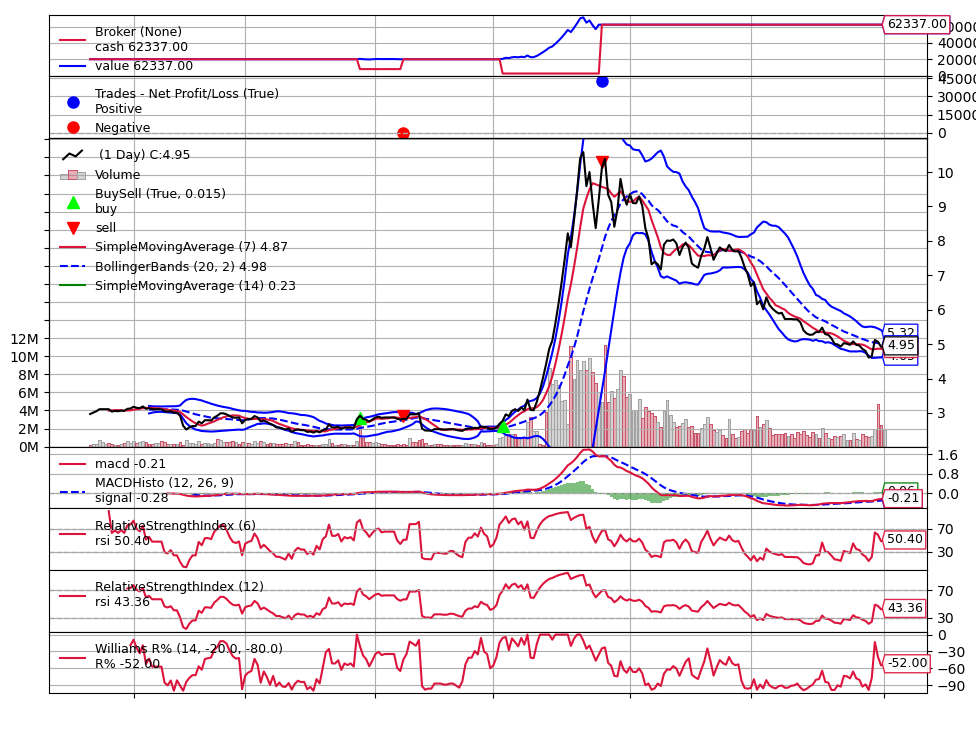

[[<Figure size 640x480 with 8 Axes>]]

In [109]:
cerebro.plot()